<a href="https://colab.research.google.com/github/ekaadev/soybean-bacterial-blight-segmentation/blob/main/soybean_bacterial_blight_model_development.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Soybean Bacterial Blight

## Configuration

In [ ]:
import os

# path
DATA_DIR = "/content/drive/MyDrive/Dataset/soybean_bacterial_blight_dataset/soybean_bacterial_blight"
TRAIN_DIR = os. path.join(DATA_DIR, "train")
VAL_DIR = os.path.join(DATA_DIR, "val")
MODEL_SAVE_PATH = "/content/drive/MyDrive/models"

# training params
BATCH_SIZE = 8
NUM_EPOCHS = 50
LEARNING_RATE = 1e-4
IMAGE_SIZE = 512
NUM_CLASSES = 3  # background, leaf, disease

# device
DEVICE = "cuda"

## Modifikasi Dataset

In [ ]:
# import library yang dibutuhkan

import os
import cv2
import numpy as np
from torch.utils.data import Dataset, DataLoader
from glob import glob

In [ ]:
# create class

class SoybeanDataset(Dataset):
  def __init__(self, image_dir, mask_dir, transform=None) -> None:
    self.image_paths = sorted(glob(f"{image_dir}/*"))
    self.mask_dir = mask_dir
    self.transform = transform

  def __len__(self):
    return len(self.image_paths)

  def __getitem__(self, idx):
    # load image
    img_path = self.image_paths[idx] # get image with idx
    image = cv2.imread(img_path) # read img
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # convert to rgb

    # load mask
    base = os.path.splitext(os.path.basename(img_path))[0]
    mask_path = os.path.join(self.mask_dir, base + ".png") # get name file
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
      raise Exception(f"Mask not found for image {img_path}")

    # convert mask to class indices
    # background=0, leaf=1 (gray-128), disease=2 (white-255)
    mask_classes = np.zeros_like(mask)
    mask_classes[mask > 200] = 2 # disease (white)
    mask_classes[(mask > 50) & (mask <= 200)] = 1 # leaf (gray)

    if self.transform:
      transformed = self.transform(image=image, mask=mask_classes)
      image = transformed["image"]
      mask_classes = transformed["mask"].long()

    return image, mask_classes

In [ ]:
# import library

import albumentations as A
from albumentations.pytorch import ToTensorV2

In [ ]:
# function transform train image
def get_train_transforms(image_size):
  return A.Compose([
      A.Resize(image_size, image_size),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5),
      A.RandomRotate90(p=0.5),
      A.RandomBrightnessContrast(p=0.2),
      A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.255]),
      ToTensorV2()
  ])

In [ ]:
# function transform val image
def get_val_transforms(image_size):
  return A.Compose([
      A.Resize(image_size, image_size),
      A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.255]),
      ToTensorV2()
  ])

In [ ]:
# import library

import sys
sys.path.append("/content/drive/MyDrive/soybean_segmentation")

In [ ]:
# create train dataset

train_dataset = SoybeanDataset(
    f"{TRAIN_DIR}/images",
    f"{TRAIN_DIR}/masks",
    transform=get_train_transforms(IMAGE_SIZE)
)

In [ ]:
# create validation dataset

val_dataset = SoybeanDataset(
    f"{VAL_DIR}/images",
    f"{VAL_DIR}/masks",
    transform=get_val_transforms(IMAGE_SIZE)
)

## Data Loader

In [ ]:
# data loader

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2) # training loader
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2) # validation loader

In [ ]:
# import library

import torch

In [ ]:
# verify

images, masks = next(iter(train_loader))
print(f"Image shape: {images.shape}, Mask shape: {masks.shape}")
print(f"Mask unique values: {torch.unique(masks)}")

Image shape: torch.Size([8, 3, 512, 512]), Mask shape: torch.Size([8, 512, 512])
Mask unique values: tensor([0, 1, 2])


## Model Development

In [ ]:
# import library

import torch
import torch.nn as nn
from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights

In [ ]:
# get model function

def get_deeplabv3(num_classes, pretrained=True):
  if pretrained:
    model = deeplabv3_resnet50(weights=DeepLabV3_ResNet50_Weights.DEFAULT)
  else:
    model = deeplabv3_resnet50(weights=None)

  # modify classifier
  model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)
  model.aux_classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)

  return model

### Metrics

In [ ]:
# kalkulasi interception over union
def calculate_iou(pred, target, num_classes):
  ious = []
  pred = pred.view(-1)
  target = target.view(-1)

  for cls in range(num_classes):
    pred_cls = pred == cls
    target_cls = target == cls
    intersection = (pred_cls & target_cls).sum().float() # bersinggungan
    union = (pred_cls | target_cls).sum().float() # gabungan

    if union == 0:
      ious.append(float('nan'))
    else:
      ious.append((intersection / union).item())

  return np.nanmean(ious)

In [ ]:
# kalkulasi dice

def calculate_dice(pred, target, num_classes):
  dices = []
  pred = pred.view(-1)
  target = target.view(-1)

  for cls in range(num_classes):
    pred_cls = pred == cls
    target_cls = target == cls
    intersection = (pred_cls & target_cls).sum().float() # bersinggungan

    if (pred_cls.sum() + target_cls.sum()) == 0:
      dices.append(float('nan'))
    else:
      dices.append((2 * intersection / (pred_cls.sum() + target_cls.sum())).item())

  return np.nanmean(dices)

### Test Model

In [ ]:
# import library

import numpy as np

In [ ]:
# testing model

model = get_deeplabv3(NUM_CLASSES)
model = model.to(DEVICE)

dummy_input = torch.randn(2, 3, 512, 512).to(DEVICE)
output = model(dummy_input)
print(f"Output shape: {output['out'].shape}")

Output shape: torch.Size([2, 3, 512, 512])


## Train Model

In [ ]:
# import library

import numpy as np
import torch
import torch.nn as nn
from torch.optim import AdamW # optimizer
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm import tqdm

In [ ]:
# import library

import sys
sys.path.append("/content/drive/MyDrive/soybean_segmentation")

In [ ]:
# inisialisasi

model = get_deeplabv3(NUM_CLASSES).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

In [ ]:
# training

history = {
    "train_loss": [],
    "val_loss": [],
    "train_iou": [],
    "val_iou": []
}

In [ ]:
# function train epoch
def train_epoch(model, loader, criterion, optimizer):
  model.train()
  total_loss = 0
  total_iou = 0

  for images, masks in tqdm(loader, desc="Training"):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    outputs = model(images)["out"]
    loss = criterion(outputs, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    preds = outputs.argmax(dim=1)
    total_iou += calculate_iou(preds, masks, NUM_CLASSES)

  return total_loss / len(loader), total_iou / len(loader)

In [ ]:
# function validate epoch
def validate_epoch(model, loader, criterion):
  model.eval()
  total_loss = 0
  total_iou = 0

  with torch.no_grad():
    for images, masks in tqdm(loader, desc="Validation"):
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      outputs = model(images)["out"]
      loss = criterion(outputs, masks)

      total_loss += loss.item()
      preds = outputs.argmax(dim=1)
      total_iou += calculate_iou(preds, masks, NUM_CLASSES)

  return total_loss / len(loader), total_iou / len(loader)

In [ ]:
# training loop
best_iou = 0
for epoch in range(NUM_EPOCHS):
  print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")

  train_loss, train_iou = train_epoch(model, train_loader, criterion, optimizer)
  val_loss, val_iou = validate_epoch(model, val_loader, criterion)
  scheduler.step()

  history["train_loss"].append(train_loss)
  history["val_loss"].append(val_loss)
  history["train_iou"].append(train_iou)
  history["val_iou"].append(val_iou)

  print(f"Train Loss: {train_loss:.4f}, Train IoU: {train_iou:.4f}")
  print(f"Val Loss: {val_loss:.4f}, Val IoU: {val_iou:.4f}")

  # save best model
  if val_iou > best_iou:
    best_iou = val_iou
    torch.save({
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "best_iou": best_iou
    }, f"{MODEL_SAVE_PATH}/best_model.pth")
    print(f"Model saved with IoU: {best_iou:.4f}")


Epoch 1/50


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.01it/s]


Train Loss: 0.5769, Train IoU: 0.5650
Val Loss: 0.4562, Val IoU: 0.5350
Model saved with IoU: 0.5350

Epoch 2/50


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


Train Loss: 0.4302, Train IoU: 0.5836
Val Loss: 0.3593, Val IoU: 0.6133
Model saved with IoU: 0.6133

Epoch 3/50


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.02it/s]


Train Loss: 0.3620, Train IoU: 0.6373
Val Loss: 0.3260, Val IoU: 0.6627
Model saved with IoU: 0.6627

Epoch 4/50


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


Train Loss: 0.3197, Train IoU: 0.6839
Val Loss: 0.2977, Val IoU: 0.6720
Model saved with IoU: 0.6720

Epoch 5/50


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.00it/s]


Train Loss: 0.2928, Train IoU: 0.6975
Val Loss: 0.2861, Val IoU: 0.6885
Model saved with IoU: 0.6885

Epoch 6/50


Validation: 100%|██████████| 2/2 [00:05<00:00,  2.51s/it]


Train Loss: 0.2693, Train IoU: 0.7191
Val Loss: 0.2791, Val IoU: 0.7123
Model saved with IoU: 0.7123

Epoch 7/50


Validation: 100%|██████████| 2/2 [00:04<00:00,  2.41s/it]


Train Loss: 0.2558, Train IoU: 0.7307
Val Loss: 0.2664, Val IoU: 0.7185
Model saved with IoU: 0.7185

Epoch 8/50


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.15s/it]


Train Loss: 0.2423, Train IoU: 0.7384
Val Loss: 0.2746, Val IoU: 0.7121

Epoch 9/50


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


Train Loss: 0.2308, Train IoU: 0.7444
Val Loss: 0.2540, Val IoU: 0.7325
Model saved with IoU: 0.7325

Epoch 10/50


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


Train Loss: 0.2211, Train IoU: 0.7523
Val Loss: 0.2508, Val IoU: 0.7326
Model saved with IoU: 0.7326

Epoch 11/50


Validation: 100%|██████████| 2/2 [00:04<00:00,  2.30s/it]


Train Loss: 0.2136, Train IoU: 0.7537
Val Loss: 0.2367, Val IoU: 0.7379
Model saved with IoU: 0.7379

Epoch 12/50


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.00it/s]


Train Loss: 0.2136, Train IoU: 0.7538
Val Loss: 0.2264, Val IoU: 0.7431
Model saved with IoU: 0.7431

Epoch 13/50


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


Train Loss: 0.2032, Train IoU: 0.7621
Val Loss: 0.2184, Val IoU: 0.7501
Model saved with IoU: 0.7501

Epoch 14/50


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.01it/s]


Train Loss: 0.1956, Train IoU: 0.7653
Val Loss: 0.2229, Val IoU: 0.7520
Model saved with IoU: 0.7520

Epoch 15/50


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


Train Loss: 0.1901, Train IoU: 0.7692
Val Loss: 0.2214, Val IoU: 0.7533
Model saved with IoU: 0.7533

Epoch 16/50


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


Train Loss: 0.1844, Train IoU: 0.7751
Val Loss: 0.2180, Val IoU: 0.7535
Model saved with IoU: 0.7535

Epoch 17/50


Validation: 100%|██████████| 2/2 [00:09<00:00,  4.66s/it]


Train Loss: 0.1802, Train IoU: 0.7767
Val Loss: 0.2136, Val IoU: 0.7584
Model saved with IoU: 0.7584

Epoch 18/50


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.02it/s]


Train Loss: 0.1782, Train IoU: 0.7765
Val Loss: 0.2071, Val IoU: 0.7625
Model saved with IoU: 0.7625

Epoch 19/50


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


Train Loss: 0.1739, Train IoU: 0.7803
Val Loss: 0.2051, Val IoU: 0.7646
Model saved with IoU: 0.7646

Epoch 20/50


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


Train Loss: 0.1729, Train IoU: 0.7820
Val Loss: 0.1997, Val IoU: 0.7596

Epoch 21/50


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


Train Loss: 0.1670, Train IoU: 0.7845
Val Loss: 0.1902, Val IoU: 0.7721
Model saved with IoU: 0.7721

Epoch 22/50


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


Train Loss: 0.1649, Train IoU: 0.7873
Val Loss: 0.1885, Val IoU: 0.7734
Model saved with IoU: 0.7734

Epoch 23/50


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


Train Loss: 0.1650, Train IoU: 0.7872
Val Loss: 0.1879, Val IoU: 0.7752
Model saved with IoU: 0.7752

Epoch 24/50


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


Train Loss: 0.1591, Train IoU: 0.7911
Val Loss: 0.1860, Val IoU: 0.7724

Epoch 25/50


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


Train Loss: 0.1560, Train IoU: 0.7922
Val Loss: 0.1824, Val IoU: 0.7757
Model saved with IoU: 0.7757

Epoch 26/50


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


Train Loss: 0.1556, Train IoU: 0.7914
Val Loss: 0.1816, Val IoU: 0.7784
Model saved with IoU: 0.7784

Epoch 27/50


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


Train Loss: 0.1546, Train IoU: 0.7936
Val Loss: 0.1783, Val IoU: 0.7794
Model saved with IoU: 0.7794

Epoch 28/50


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.02it/s]


Train Loss: 0.1553, Train IoU: 0.7899
Val Loss: 0.1771, Val IoU: 0.7796
Model saved with IoU: 0.7796

Epoch 29/50


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


Train Loss: 0.1513, Train IoU: 0.7948
Val Loss: 0.1789, Val IoU: 0.7790

Epoch 30/50


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


Train Loss: 0.1505, Train IoU: 0.7955
Val Loss: 0.1770, Val IoU: 0.7789

Epoch 31/50


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


Train Loss: 0.1500, Train IoU: 0.7942
Val Loss: 0.1743, Val IoU: 0.7792

Epoch 32/50


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


Train Loss: 0.1479, Train IoU: 0.7959
Val Loss: 0.1737, Val IoU: 0.7809
Model saved with IoU: 0.7809

Epoch 33/50


Validation: 100%|██████████| 2/2 [00:06<00:00,  3.12s/it]


Train Loss: 0.1474, Train IoU: 0.7968
Val Loss: 0.1736, Val IoU: 0.7822
Model saved with IoU: 0.7822

Epoch 34/50


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


Train Loss: 0.1469, Train IoU: 0.7966
Val Loss: 0.1719, Val IoU: 0.7810

Epoch 35/50


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


Train Loss: 0.1470, Train IoU: 0.7975
Val Loss: 0.1708, Val IoU: 0.7843
Model saved with IoU: 0.7843

Epoch 36/50


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


Train Loss: 0.1452, Train IoU: 0.7975
Val Loss: 0.1710, Val IoU: 0.7832

Epoch 37/50


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


Train Loss: 0.1465, Train IoU: 0.7963
Val Loss: 0.1707, Val IoU: 0.7841

Epoch 38/50


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


Train Loss: 0.1463, Train IoU: 0.7983
Val Loss: 0.1696, Val IoU: 0.7842

Epoch 39/50


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


Train Loss: 0.1433, Train IoU: 0.7996
Val Loss: 0.1693, Val IoU: 0.7833

Epoch 40/50


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


Train Loss: 0.1438, Train IoU: 0.7986
Val Loss: 0.1686, Val IoU: 0.7841

Epoch 41/50


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


Train Loss: 0.1441, Train IoU: 0.7990
Val Loss: 0.1692, Val IoU: 0.7846
Model saved with IoU: 0.7846

Epoch 42/50


Validation: 100%|██████████| 2/2 [00:05<00:00,  2.82s/it]


Train Loss: 0.1441, Train IoU: 0.7976
Val Loss: 0.1685, Val IoU: 0.7847
Model saved with IoU: 0.7847

Epoch 43/50


Validation: 100%|██████████| 2/2 [00:05<00:00,  2.89s/it]


Train Loss: 0.1427, Train IoU: 0.7991
Val Loss: 0.1690, Val IoU: 0.7847
Model saved with IoU: 0.7847

Epoch 44/50


Validation: 100%|██████████| 2/2 [00:06<00:00,  3.06s/it]


Train Loss: 0.1427, Train IoU: 0.7993
Val Loss: 0.1693, Val IoU: 0.7841

Epoch 45/50


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


Train Loss: 0.1434, Train IoU: 0.7985
Val Loss: 0.1694, Val IoU: 0.7837

Epoch 46/50


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


Train Loss: 0.1425, Train IoU: 0.7991
Val Loss: 0.1681, Val IoU: 0.7846

Epoch 47/50


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.02it/s]


Train Loss: 0.1426, Train IoU: 0.7979
Val Loss: 0.1688, Val IoU: 0.7843

Epoch 48/50


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


Train Loss: 0.1429, Train IoU: 0.7977
Val Loss: 0.1687, Val IoU: 0.7843

Epoch 49/50


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


Train Loss: 0.1418, Train IoU: 0.8006
Val Loss: 0.1683, Val IoU: 0.7842

Epoch 50/50


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


Train Loss: 0.1417, Train IoU: 0.8005
Val Loss: 0.1678, Val IoU: 0.7851
Model saved with IoU: 0.7851


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# function plot training history
def plot_training_history(train_losses, val_losses, train_ious, val_ious):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

  ax1.plot(train_losses, label="Train")
  ax1. plot(val_losses, label="Val")
  ax1.set_title("Loss")
  ax1. legend()

  ax2.plot(train_ious, label="Train")
  ax2. plot(val_ious, label="Val")
  ax2.set_title("mIoU")
  ax2.legend()

  plt.show()

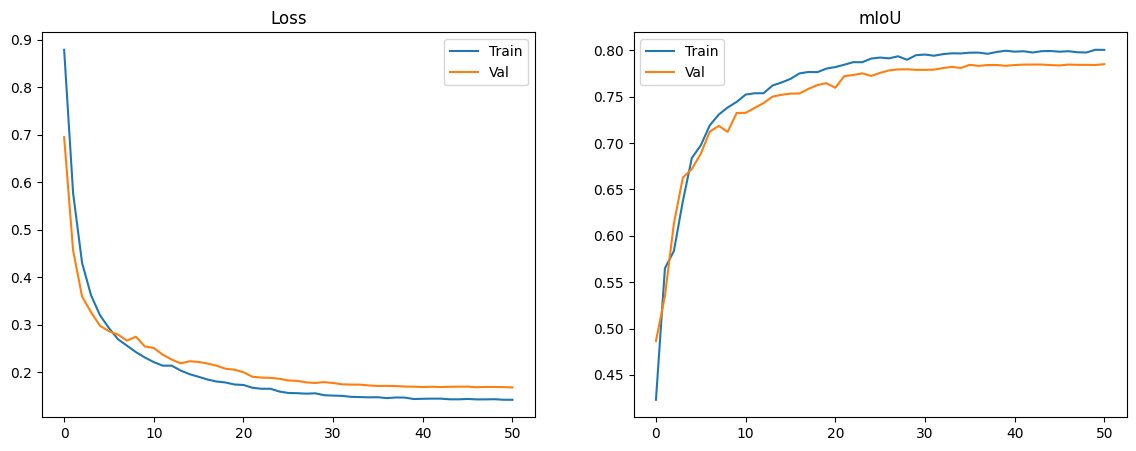

In [ ]:
plot_training_history(
    history["train_loss"],
    history["val_loss"],
    history["train_iou"],
    history["val_iou"]
)

## Evaluate Model

In [ ]:
# import library

import torch
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# import library

import sys
sys.path.append("/content/drive/MyDrive/soybean_segmentation")

### Load Best Model

In [ ]:
# load model
model = get_deeplabv3(NUM_CLASSES).to(DEVICE)
checkpoint = torch.load(f"{MODEL_SAVE_PATH}/best_model.pth", weights_only=False) # get best model
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

### Evaluate

In [ ]:
# evaluate

all_preds = []
all_targets = []

with torch.no_grad():
  for images, masks in val_loader:
    images = images.to(DEVICE)
    outputs = model(images)["out"]
    preds = outputs.argmax(dim=1).cpu().numpy()

    all_preds.extend(preds.flatten())
    all_targets.extend(masks.numpy().flatten())

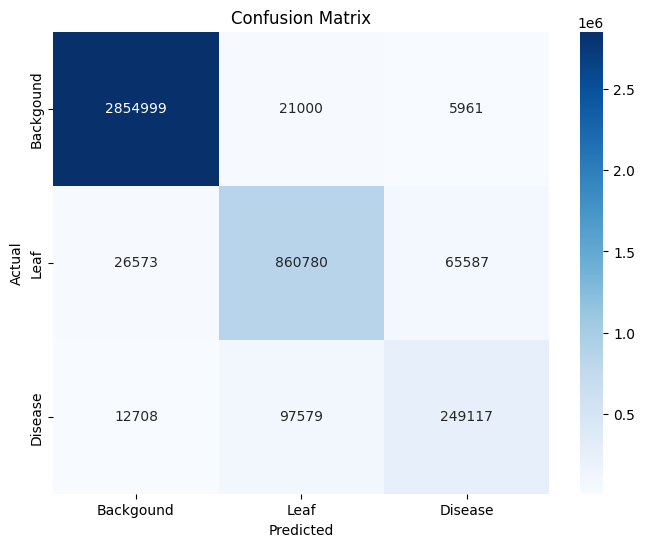

In [ ]:
# confusion matrix

cm = confusion_matrix(all_targets, all_preds)
class_name = ["Backgound", "Leaf", "Disease"]

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_name, yticklabels=class_name)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# per-class IoU

def per_class_iou(cm):
  intersection = np.diag(cm)
  union = cm.sum(axis=1) + cm.sum(axis=0) - intersection
  iou = intersection / (union + 1e-10)
  return iou

In [ ]:
# print iou per class

ious = per_class_iou(cm)
for name, iou in zip(class_name, ious):
  print(f"{name}: {iou:.4f}")
print(f"mIoU: {np.mean(ious):.4f}")

Backgound: 0.9773
Leaf: 0.8033
Disease: 0.5781
mIoU: 0.7862


## Inference

In [ ]:
# import library

import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# import library

import sys
sys.path.append("/content/drive/MyDrive/soybean_segmentation")

In [ ]:
# load model
model = get_deeplabv3(NUM_CLASSES).to(DEVICE)
checkpoint = torch.load(f"{MODEL_SAVE_PATH}/best_model.pth", weights_only=False) # get best model
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [ ]:
# function predict

def predict(image_path):
  # load image
  image = cv2.imread(image_path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  original = image.copy()

  # transform
  transform = get_val_transforms(IMAGE_SIZE)
  transformed = transform(image=image)
  input_tensor = transformed["image"].unsqueeze(0).to(DEVICE)

  # predict
  with torch.no_grad():
    output = model(input_tensor)["out"]
    pred = output.argmax(dim=1).squeeze().cpu().numpy()

  # resize prediction to original size
  pred_resized = cv2.resize(pred.astype(np.uint8), (original.shape[1], original.shape[0]), interpolation=cv2.INTER_NEAREST)

  return original, pred_resized

In [ ]:
# function visualiasi prediksi

def visualize_prediction(image_path):
  original, pred = predict(image_path)

  # color map
  color_map = np.array([
      [0, 0, 0],       # background - black
      [0, 255, 0],     # leaf - green
      [255, 0, 0]      # disease - red
  ])

  colored_mask = color_map[pred]

  # overlay
  overlay = cv2.addWeighted(original, 0.6, colored_mask.astype(np.uint8), 0.4, 0)

  fig, axes = plt.subplots(1, 3, figsize=(15, 5))
  axes[0].imshow(original)
  axes[0].set_title("Original")
  axes[0].axis("off")

  axes[1].imshow(colored_mask.astype(np.uint8))
  axes[1].set_title("Prediction")
  axes[1].axis("off")

  axes[2].imshow(overlay)
  axes[2].set_title("Overlay")
  axes[2].axis("off")

  plt.tight_layout()
  plt.show()

  # calculate disease percentage
  total_leaf = np.sum(pred >= 1)
  disease_area = np.sum(pred == 2)
  if total_leaf > 0:
    disease_percentage = (disease_area / total_leaf) * 100
    print(f"Disease coverage: {disease_percentage:.2f}%")

## Testing Result

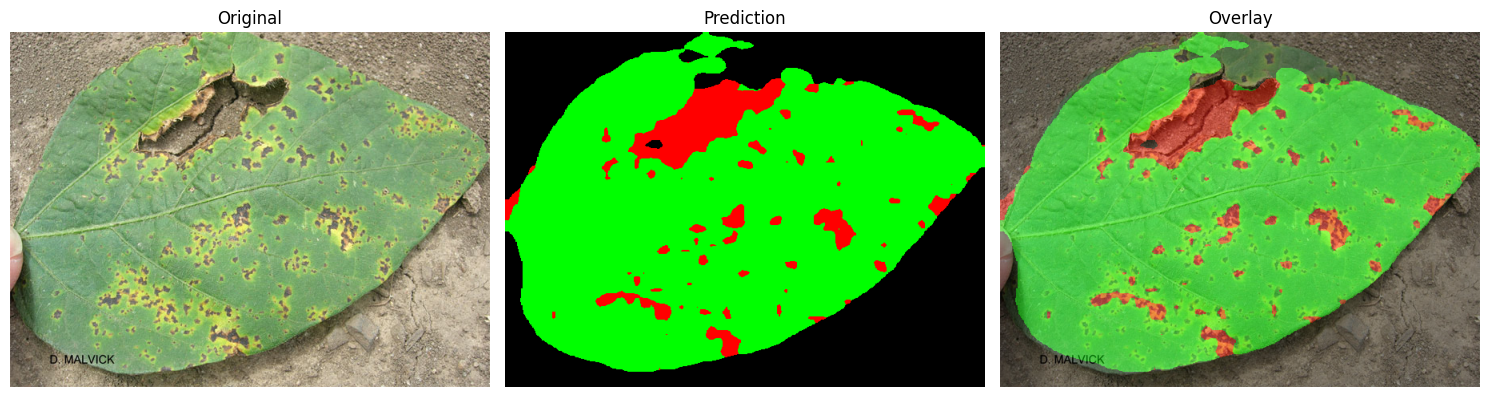

Disease coverage: 10.85%


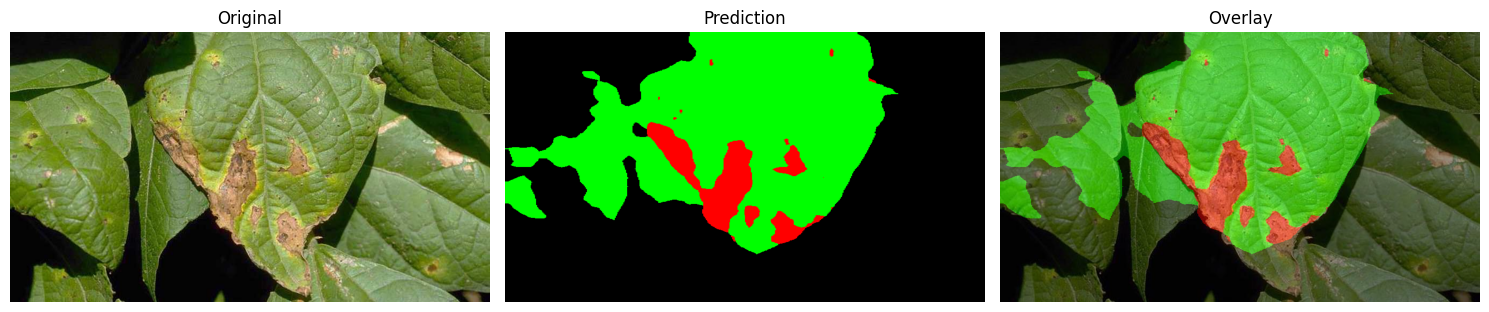

Disease coverage: 11.68%


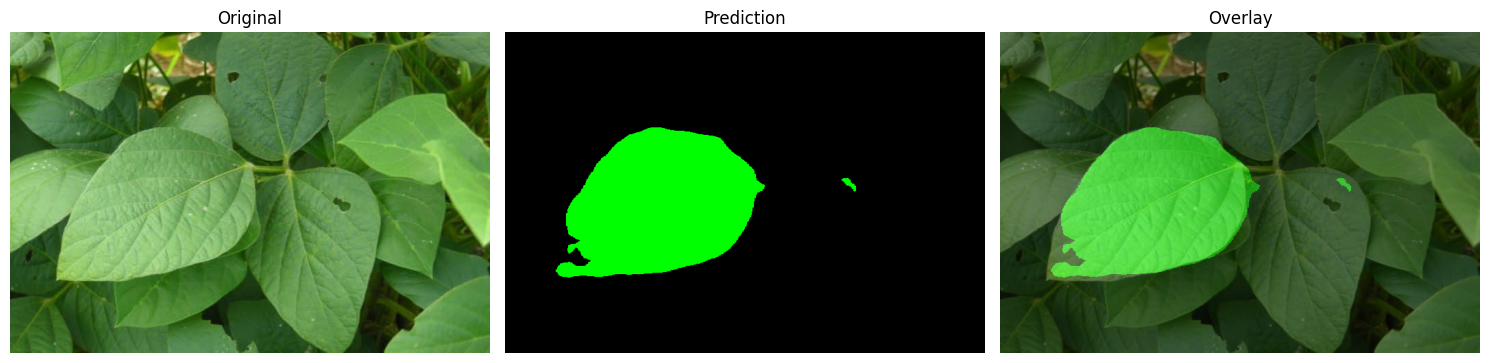

Disease coverage: 0.00%


In [ ]:
# testing

for i in [1, 5, 7]:
  visualize_prediction(f"/content/testing_images/Bacterial_Blight_of_Soybean_Contoh_{i}.jpg")